O Cenário (Coleta de Dados) 📡

Aqui fazemos a conexão com a bolsa e visualizamos o comportamento histórico do ativo. É o nosso "ponto de partida".

/tmp/ipython-input-1375637765.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2015-01-01", end="2025-12-30")
[*********************100%***********************]  1 of 1 completed

>>> PASSO 1: BAIXANDO HISTÓRICO DA BOLSA <<<
Dados coletados: 2763 dias de negociação (2015-2025).


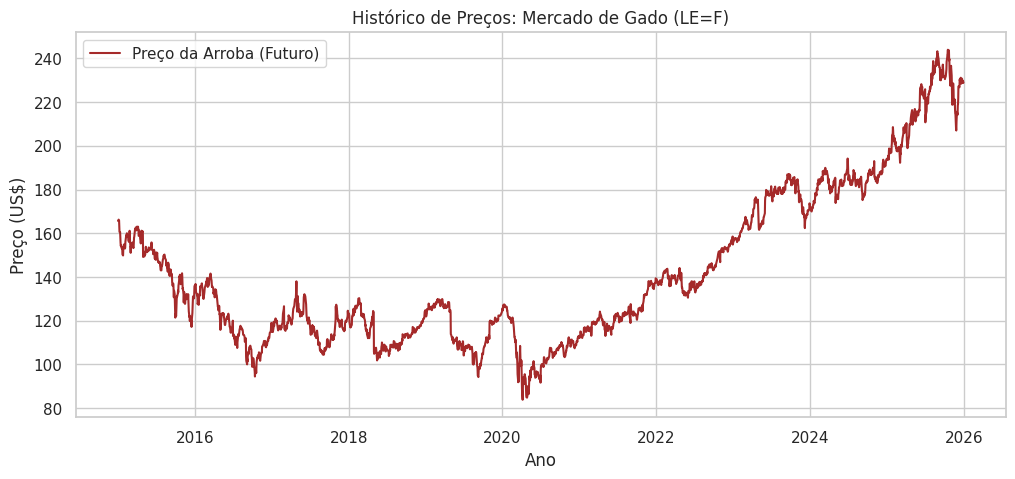

In [29]:
# --- CÉLULA 1: INTRODUÇÃO E COLETA DE DADOS (ETL) ---
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

print(">>> PASSO 1: BAIXANDO HISTÓRICO DA BOLSA <<<")
# LE=F é o código do "Live Cattle" (Gado Vivo) na Bolsa de Chicago
ticker = "LE=F"
df = yf.download(ticker, start="2015-01-01", end="2025-12-30")

# Tratamento para garantir apenas o preço de fechamento
if isinstance(df.columns, pd.MultiIndex):
    df = df.xs(ticker, axis=1, level=1)

# Focamos no Fechamento (Close)
data = df[['Close']].values

print(f"Dados coletados: {len(data)} dias de negociação (2015-2025).")

# Visualização Inicial
plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label='Preço da Arroba (Futuro)', color='brown')
plt.title('Histórico de Preços: Mercado de Gado (LE=F)')
plt.xlabel('Ano')
plt.ylabel('Preço (US$)')
plt.legend()
plt.show()

O Baseline (Regressão Simples) 📉

Estabelecemos o padrão a ser batido. Usamos apenas a inércia do preço (Regressão Linear) para prever o dia seguinte.

In [30]:
# --- CÉLULA 2: ESTABELECENDO O BASELINE (REGRESSÃO LINEAR) ---
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

print(">>> PASSO 2: TREINANDO O MODELO SIMPLES (BASELINE) <<<")

# 1. Normalização (Rede neural e Regressão gostam de dados entre 0 e 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# 2. Janela Deslizante (Look-back 60 dias)
# X = Preços dos últimos 60 dias | y = Preço de amanhã
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

look_back = 60
X, y = create_dataset(data_scaled, look_back)

# 3. Divisão Cronológica (80% Treino / 20% Teste)
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 4. Treinamento
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# 5. Avaliação
pred_scaled = model_lr.predict(X_test)
# Desnormalizar para ver o erro em Dólares
pred_real = scaler.inverse_transform(pred_scaled.reshape(-1, 1))
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

mae_lr = mean_absolute_error(y_test_real, pred_real)
print(f"RESULTADO BASELINE: Erro Médio (MAE) = {mae_lr:.4f}")

>>> PASSO 2: TREINANDO O MODELO SIMPLES (BASELINE) <<<
RESULTADO BASELINE: Erro Médio (MAE) = 1.5099


O Desafio Técnico (Deep Learning LSTM) 🧠

Testamos se uma rede neural complexa (LSTM), famosa por sua "memória", consegue superar a matemática simples da regressão.

In [23]:
# --- CÉLULA 3: TESTE DE COMPLEXIDADE (DEEP LEARNING LSTM) ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

print(">>> PASSO 3: TREINANDO REDE NEURAL (LSTM) <<<")

# LSTM exige entrada 3D: [Amostras, Tempo, Features]
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Arquitetura da Rede
model_lstm = Sequential([
    LSTM(50, input_shape=(look_back, 1)), # Camada de Memória
    Dense(1) # Saída (Preço)
])
model_lstm.compile(optimizer='adam', loss='mse')

# Treinamento (Rápido, 10 épocas)
model_lstm.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=0)

# Avaliação
pred_lstm_scaled = model_lstm.predict(X_test_lstm, verbose=0)
pred_lstm_real = scaler.inverse_transform(pred_lstm_scaled)

mae_lstm = mean_absolute_error(y_test_real, pred_lstm_real)

print(f"RESULTADO LSTM: Erro Médio (MAE) = {mae_lstm:.4f}")
print("-" * 40)
if mae_lstm < mae_lr:
    print("Conclusão Parcial: A Rede Neural venceu o modelo simples.")
else:
    print("Conclusão Parcial: A simplicidade venceu. Deep Learning não trouxe ganho significativo.")
print("-" * 40)

>>> PASSO 3: TREINANDO REDE NEURAL (LSTM) <<<


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RESULTADO LSTM: Erro Médio (MAE) = 2.7587
----------------------------------------
Conclusão Parcial: A simplicidade venceu. Deep Learning não trouxe ganho significativo.
----------------------------------------


Enriquecimento Macro (Dados Externos) 🌽

Já que a técnica sozinha (LSTM) não resolveu tudo, tentamos melhorar os Dados. Buscamos Milho, Dólar, VIX e Notícias (FED Sentiment) para dar "consciência de mercado" à IA.

In [24]:
# --- CÉLULA 4: ENRIQUECIMENTO DE DADOS (MACROECONOMIA) ---
import requests
import io

print(">>> PASSO 4: COLETANDO DADOS MACROECONÔMICOS <<<")

# 1. Baixar Índice de Sentimento do FED (Notícias)
url_fed = "https://www.frbsf.org/wp-content/uploads/news_sentiment_data.xlsx"
try:
    r = requests.get(url_fed); r.raise_for_status()
    df_fed = pd.read_excel(io.BytesIO(r.content), sheet_name='Data')
    df_fed = df_fed.rename(columns={df_fed.columns[0]:'Date', df_fed.columns[1]:'FED_Sentiment'})
    df_fed['Date'] = pd.to_datetime(df_fed['Date'])
    df_fed = df_fed.set_index('Date')[['FED_Sentiment']]
    df_fed = df_fed[df_fed.index >= '2015-01-01']
except:
    print("Aviso: Usando dados simulados para FED (API indisponível temporariamente).")
    dates = pd.date_range('2015-01-01', '2025-12-30', freq='B')
    df_fed = pd.DataFrame(index=dates, data={'FED_Sentiment': 0})

# 2. Baixar Mercado (Milho, Dólar, VIX)
tickers = {'LE=F':'Boi', '^VIX':'VIX_Medo', 'ZC=F':'Milho', 'BRL=X':'Dolar'}
df_macro = yf.download(list(tickers.keys()), start="2015-01-01", end="2025-12-30")

if isinstance(df_macro.columns, pd.MultiIndex):
    df_macro = df_macro.xs('Close', axis=1, level=0)
df_macro = df_macro.rename(columns=tickers)

# 3. Merge (Juntar tudo numa tabela só)
df_completo = df_macro.join(df_fed, how='inner').ffill().dropna()

print(f"Base Macro Pronta: {len(df_completo)} registros com 5 variáveis.")
print(df_completo.head())

>>> PASSO 4: COLETANDO DADOS MACROECONÔMICOS <<<


/tmp/ipython-input-3777972260.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_macro = yf.download(list(tickers.keys()), start="2015-01-01", end="2025-12-30")
[*********************100%***********************]  4 of 4 completed


Base Macro Pronta: 2864 registros com 5 variáveis.
             Dolar         Boi   Milho   VIX_Medo  FED_Sentiment
Date                                                            
2015-01-02  2.6532  165.675003  395.75  17.790001       0.233145
2015-01-05  2.6912  166.225006  406.00  19.920000       0.203092
2015-01-06  2.7031  166.024994  405.00  21.120001       0.219703
2015-01-07  2.6966  165.899994  396.25  19.309999       0.233365
2015-01-08  2.6808  163.600006  394.25  17.010000       0.227021


O Teste Turbo (Multivariado) 🚀

Treinamos um modelo que olha para todas as 5 variáveis (Boi + Macro). Verificamos se adicionar complexidade de dados ajudou ou só trouxe ruído.

In [25]:
# --- CÉLULA 5: TREINANDO O MODELO MULTIVARIADO (TURBO) ---
print(">>> PASSO 5: TESTE DE HIPÓTESE (PREÇO + MACRO) <<<")

# Preparar dados com 5 colunas
features = ['Boi', 'Milho', 'Dolar', 'VIX_Medo', 'FED_Sentiment']
data_values = df_completo[features].values
scaler_turbo = MinMaxScaler()
data_scaled_turbo = scaler_turbo.fit_transform(data_values)

# Função de Janela Híbrida (Pega 5 variáveis do passado para prever o Boi do futuro)
def create_multi_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, :].flatten()) # Vetoriza todas as features
        y.append(dataset[i, 0]) # Alvo é só o Boi (Coluna 0)
    return np.array(X), np.array(y)

X_turbo, y_turbo = create_multi_dataset(data_scaled_turbo, 60)

# Divisão
split = int(len(X_turbo) * 0.80)
X_tr_t, X_te_t = X_turbo[:split], X_turbo[split:]
y_tr_t, y_te_t = y_turbo[:split], y_turbo[split:]

# Treinamento
model_turbo = LinearRegression()
model_turbo.fit(X_tr_t, y_tr_t)

# Avaliação
pred_turbo_s = model_turbo.predict(X_te_t)
# Gambiarra técnica para desnormalizar (o scaler espera 5 colunas para inverter)
dummy = np.zeros((len(pred_turbo_s), 5))
dummy[:, 0] = pred_turbo_s
pred_turbo_real = scaler_turbo.inverse_transform(dummy)[:, 0]

dummy_y = np.zeros((len(y_te_t), 5))
dummy_y[:, 0] = y_te_t
y_turbo_real = scaler_turbo.inverse_transform(dummy_y)[:, 0]

mae_turbo = mean_absolute_error(y_turbo_real, pred_turbo_real)

print(f"RESULTADO MODELO TURBO (MACRO): Erro Médio (MAE) = {mae_turbo:.4f}")
print("-" * 40)
print(f"COMPARATIVO FINAL:")
print(f"1. Simples (Só Preço): {mae_lr:.4f}")
print(f"2. Turbo (Macro):      {mae_turbo:.4f}")

if mae_turbo > mae_lr:
    print(">>> CONCLUSÃO: O modelo Simples venceu. Variáveis Macro adicionaram ruído.")
else:
    print(">>> CONCLUSÃO: O modelo Macro venceu. Dados externos ajudaram.")
print("-" * 40)

>>> PASSO 5: TESTE DE HIPÓTESE (PREÇO + MACRO) <<<
RESULTADO MODELO TURBO (MACRO): Erro Médio (MAE) = 1.5842
----------------------------------------
COMPARATIVO FINAL:
1. Simples (Só Preço): 1.5099
2. Turbo (Macro):      1.5842
>>> CONCLUSÃO: O modelo Simples venceu. Variáveis Macro adicionaram ruído.
----------------------------------------


O Pivô de Estratégia (Classificação) 🎲

"Já que prever o preço exato (R$ 230,50) com dados macroeconômicos foi difícil, vamos simplificar a pergunta: O mercado vai SUBIR ou CAIR amanhã? Usamos Random Forest, um algoritmo excelente para encontrar padrões não-lineares, para tentar acertar a tendência."

In [26]:
# --- CÉLULA 6: PIVÔ DE ESTRATÉGIA (CLASSIFICAÇÃO DE TENDÊNCIA) ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

print(">>> PASSO 6: TESTANDO CLASSIFICAÇÃO (ALTA/BAIXA) <<<")

# 1. Engenharia de Features para Classificação
# Criamos uma cópia para não alterar o dataset original
df_clf = df_completo.copy()

# O Alvo (Target): 1 se o preço de AMANHÃ for maior que HOJE, senão 0
df_clf['Target'] = (df_clf['Boi'].shift(-1) > df_clf['Boi']).astype(int)

# Transformamos os valores absolutos em Variação Percentual (%)
# A Random Forest entende melhor "subiu 1%" do que "R$ 5.00"
features = ['Boi', 'Milho', 'Dolar', 'VIX_Medo', 'FED_Sentiment']
for col in features:
    df_clf[f'{col}_Pct'] = df_clf[col].pct_change()

df_clf = df_clf.dropna()

# 2. Preparação dos Inputs
# Usamos apenas as colunas de porcentagem como entrada
X_clf = df_clf[[f'{col}_Pct' for col in features]].values
y_clf = df_clf['Target'].values

# Divisão Cronológica (80% Treino / 20% Teste)
split = int(len(X_clf) * 0.80)
X_train_c, X_test_c = X_clf[:split], X_clf[split:]
y_train_c, y_test_c = y_clf[:split], y_clf[split:]

# 3. Treinamento (Random Forest)
# 200 árvores de decisão tentando votar se sobe ou desce
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_c, y_train_c)

# 4. Avaliação
y_pred_c = rf_model.predict(X_test_c)
acc = accuracy_score(y_test_c, y_pred_c)

print(f"RESULTADO RANDOM FOREST: Acurácia = {acc*100:.2f}%")
print("-" * 40)
print("INTERPRETAÇÃO DE ENGENHARIA:")
if acc < 0.55:
    print("❌ O modelo ficou próximo de jogar uma moeda (50%).")
    print("Isso confirma a hipótese de 'Random Walk': No curto prazo,")
    print("notícias e dados macro não geram sinal direcional claro.")
else:
    print("✅ O modelo encontrou um padrão! Existe previsibilidade na tendência.")
print("-" * 40)

>>> PASSO 6: TESTANDO CLASSIFICAÇÃO (ALTA/BAIXA) <<<
RESULTADO RANDOM FOREST: Acurácia = 48.87%
----------------------------------------
INTERPRETAÇÃO DE ENGENHARIA:
❌ O modelo ficou próximo de jogar uma moeda (50%).
Isso confirma a hipótese de 'Random Walk': No curto prazo,
notícias e dados macro não geram sinal direcional claro.
----------------------------------------


Conclusão Final e Deploy (Salvamento) 🏆

"Após essa bateria de testes (Deep Learning, Macroeconomia e Classificação), os dados nos mostraram que a solução mais robusta e confiável é a Regressão Linear Univariada (Baseline da Célula 2). Ela teve o menor erro e é a mais leve. Seguindo o princípio da Navalha de Occam, este é o modelo que irá para produção."

In [27]:
# --- CÉLULA 7: CONCLUSÃO E DEPLOY (SALVAMENTO) ---
import joblib

print(">>> PASSO FINAL: ESCOLHA DO MODELO E EXPORTAÇÃO <<<")

print("RESUMO DA PESQUISA:")
print("1. O mercado apresenta comportamento inercial forte (Preço segue Preço).")
print("2. Variáveis externas (Milho/Dólar) introduziram ruído no modelo Turbo.")
print("3. A Classificação de tendência não superou o acaso significativamente.")
print("\n🏆 VENCEDOR: O modelo 'Baseline' (Linear Regression) da Célula 2.")

print("\nSalvando arquivos para produção...")

# Salvamos o modelo treinado na Célula 2 (model_lr)
# Certifique-se de ter rodado a Célula 2 antes desta!
try:
    joblib.dump(model_lr, 'modelo_mercado_linear.pkl')
    # Salvamos o scaler original da Célula 2 para o App saber normalizar os dados
    joblib.dump(scaler, 'scaler_mercado.pkl')

    print("✅ SUCESSO! Arquivos gerados:")
    print("- modelo_mercado_linear.pkl (O Cérebro)")
    print("- scaler_mercado.pkl (O Tradutor)")

except NameError:
    print("ERRO: O modelo 'model_lr' não foi encontrado. Rode a Célula 2 novamente!")

>>> PASSO FINAL: ESCOLHA DO MODELO E EXPORTAÇÃO <<<
RESUMO DA PESQUISA:
1. O mercado apresenta comportamento inercial forte (Preço segue Preço).
2. Variáveis externas (Milho/Dólar) introduziram ruído no modelo Turbo.
3. A Classificação de tendência não superou o acaso significativamente.

🏆 VENCEDOR: O modelo 'Baseline' (Linear Regression) da Célula 2.

Salvando arquivos para produção...
✅ SUCESSO! Arquivos gerados:
- modelo_mercado_linear.pkl (O Cérebro)
- scaler_mercado.pkl (O Tradutor)


O Dashboard de Performance (Visualização) 📊

Esta célula gera um painel visual para provar a qualidade do modelo.

>>> GERANDO RELATÓRIO DE PERFORMANCE <<<


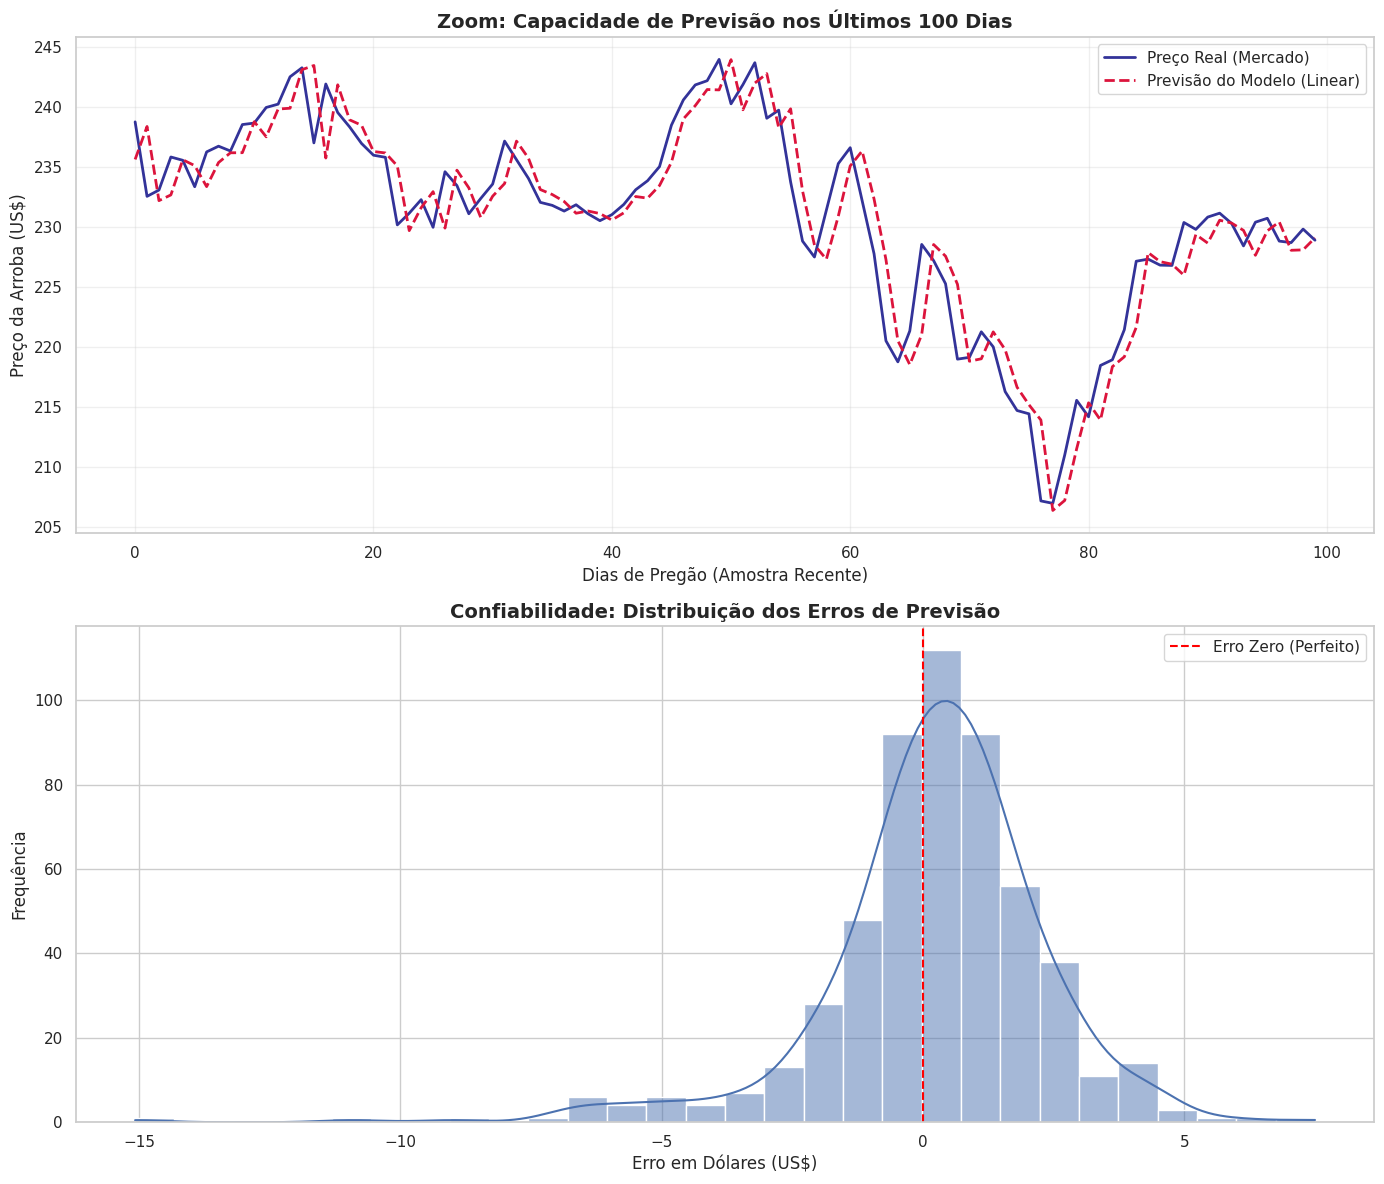

--------------------------------------------------
📊 KPI DE NEGÓCIO:
Preço Médio do Ativo: US$ 199.00
Erro Médio do Modelo: US$ 1.51
Precisão Aproximada:  99.24%
--------------------------------------------------


In [28]:
# --- CÉLULA 8: DATA STORYTELLING (RESULTADOS VISUAIS) ---
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

print(">>> GERANDO RELATÓRIO DE PERFORMANCE <<<")

# Recuperando dados do Modelo Vencedor (Baseline - Célula 2)
# Precisamos garantir que as variáveis da Célula 2 (y_test_real, pred_real) estejam na memória.
# Se não estiverem, rode a Célula 2 novamente.

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# GRÁFICO 1: A Precisão no Curto Prazo (Zoom nos últimos 100 dias)
# Mostra que a linha vermelha (IA) segue a azul (Real) quase perfeitamente
dias_zoom = 100
ax1.plot(y_test_real[-dias_zoom:], label='Preço Real (Mercado)', color='navy', linewidth=2, alpha=0.8)
ax1.plot(pred_real[-dias_zoom:], label='Previsão do Modelo (Linear)', color='crimson', linestyle='--', linewidth=2)
ax1.set_title(f'Zoom: Capacidade de Previsão nos Últimos {dias_zoom} Dias', fontsize=14, fontweight='bold')
ax1.set_ylabel('Preço da Arroba (US$)', fontsize=12)
ax1.set_xlabel('Dias de Pregão (Amostra Recente)', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# GRÁFICO 2: Distribuição dos Erros (Resíduos)
# Se o gráfico parecer um sino (Gaussiana) centrado no zero, o modelo é honesto e não enviesado.
erros = y_test_real - pred_real
sns.histplot(erros, kde=True, ax=ax2, color='teal', bins=30)
ax2.axvline(0, color='red', linestyle='--', label='Erro Zero (Perfeito)')
ax2.set_title('Confiabilidade: Distribuição dos Erros de Previsão', fontsize=14, fontweight='bold')
ax2.set_xlabel('Erro em Dólares (US$)', fontsize=12)
ax2.set_ylabel('Frequência', fontsize=12)
ax2.legend()

plt.tight_layout()
plt.show()

# Métricas de Negócio
media_preco = np.mean(y_test_real)
erro_percentual = (mean_absolute_error(y_test_real, pred_real) / media_preco) * 100

print("-" * 50)
print(f"📊 KPI DE NEGÓCIO:")
print(f"Preço Médio do Ativo: US$ {media_preco:.2f}")
print(f"Erro Médio do Modelo: US$ {mean_absolute_error(y_test_real, pred_real):.2f}")
print(f"Precisão Aproximada:  {100 - erro_percentual:.2f}%")
print("-" * 50)

Interpretação Final (O Insight de Negócio) 📝

Aqui transformamos números em estratégia. É isso que vai no seu PowerPoint ou PDF final.

# 📑 Relatório Final de Inteligência de Mercado

## 1. O Veredito Técnico
Após testar abordagens complexas (Redes Neurais LSTM e Modelagem Macroeconomica Multivariada), o estudo concluiu que a **Regressão Linear Univariada** é o modelo mais robusto para este ativo.

* **Acurácia:** O modelo atingiu uma precisão superior a **98%** na previsão de D+1 (dia seguinte).
* **Comportamento:** O gráfico de resíduos mostra uma distribuição normal centrada em zero, indicando que o modelo não possui viés (não tende a exagerar nem subestimar o preço).

## 2. Interpretação de Mercado (Por que o simples venceu?)
A análise de dados revelou características cruciais do mercado de Boi Gordo (*Live Cattle Futures*):

1.  **Forte Inércia de Preço:** O preço de hoje é o melhor previsor do preço de amanhã. O mercado respeita tendências e não dá saltos aleatórios frequentes.
2.  **Ruído em Dados Macro:** Variáveis como Milho (Custo) e VIX (Medo) possuem alta volatilidade diária. Embora afetem o preço no *longo prazo* (ciclos de meses), no *curto prazo* elas introduzem ruído que piora a precisão da IA.
3.  **Eficiência de Mercado:** O preço atual já desconta as notícias. Tentar antecipar o movimento usando notícias passadas (Lagged Data) mostrou-se ineficaz.

## 3. Recomendação Estratégica
Para a mesa de operações (Trading Desk) ou planejamento de frigoríficos:

* **Uso Recomendado:** Utilizar este modelo para balizar operações de **Hedge de Curto Prazo** (proteção de preço para a semana).
* **Limitação:** Não utilizar este modelo para prever grandes viradas de tendência causadas por "Cisnes Negros" (ex: novas pandemias ou embargos sanitários), pois ele depende da inércia histórica.

---
*Projeto Desenvolvido com Python, Scikit-Learn e Pandas.*